In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

In [32]:
cred_trans = pd.read_csv('data/ibm_card_data_unlabelled.csv')
cred_trans.head()

User  Card  Year  Month  Day   Time   Amount           Use Chip  \
0     0     0  2002      9    2  17:45  $128.95  Swipe Transaction   
1     0     0  2002      9    8  13:48   $76.57  Swipe Transaction   
2     0     0  2002      9   10  06:22  $102.18  Swipe Transaction   
3     0     0  2002      9   12  06:21  $122.10  Swipe Transaction   
4     0     0  2002      9   23  06:46   $35.28  Swipe Transaction   

         Merchant Name  Merchant City Merchant State      Zip   MCC  \
0  3414527459579106770  Monterey Park             CA  91754.0  5651   
1  -727612092139916043  Monterey Park             CA  91754.0  5411   
2  3527213246127876953       La Verne             CA  91750.0  5300   
3  4060646732831064559       La Verne             CA  91750.0  5411   
4   -34551508091458520       La Verne             CA  91750.0  5912   

                Errors?  
0                   NaN  
1                   NaN  
2                   NaN  
3  Insufficient Balance  
4                   NaN

In [33]:
## Let's remove the white space in the columns and replace them with underscore
cred_trans.columns = [x.replace(" ", "_").replace("?", "") for x in cred_trans.columns]
cred_trans.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use_Chip',
       'Merchant_Name', 'Merchant_City', 'Merchant_State', 'Zip', 'MCC',
       'Errors'],
      dtype='object')

## Feature Engineering

## FEATURE ENGINEERING
> ### Filling missing values using fillna
> ### Changing the Name of the 'Amount' column
> ### Creating bins for certain columns
> ### Changing the Time column to a 24hr format

In [34]:
def feature_eng(df):
    """ Function to fill nulls and label encode the following columns: 'Errors', 'Use_Chip', 'Merchant_City', 'Merchant_State' """
    cols_to_encode = ['Errors', 'Use_Chip', 'Merchant_City', 'Merchant_State']
    trans = df.copy()
    labelencoder = LabelEncoder()

    # label encoding categrical column values
    for col in cols_to_encode:
        trans[col].fillna("0", inplace = True)
        trans[col + '_Encoded'] = labelencoder.fit_transform(trans[col]) ## Label encoding all stated columns so that later our algorithm can understand the numerical data

    ## Removing the Dollar sign from the Amount column in order to change object to float.
    trans['Amount'] = trans['Amount'].replace({'\$' : ''}, regex=True).astype(float)

    trans.drop(cols_to_encode, axis=1, inplace=True) ## Dropping the original columns, since we have now created new encoded columns

    trans['Zip'].fillna(0, inplace = True) ## Filling all null values in the zip column with 0
    trans['Time'] = trans['Time'].str[:2].astype('int')
    trans['Suspected_Fraud'] = np.where(trans['Errors_Encoded']!= 0, 1, 0) ## Classifying suspected fraud with a 1 (i.e. the rows which have erroneous transactions, otherwise a 0.

    return trans

cred_trans = feature_eng(cred_trans)

In [35]:
cred_trans.head(10)

User  Card  Year  Month  Day  Time  Amount        Merchant_Name      Zip  \
0     0     0  2002      9    2    17  128.95  3414527459579106770  91754.0   
1     0     0  2002      9    8    13   76.57  -727612092139916043  91754.0   
2     0     0  2002      9   10     6  102.18  3527213246127876953  91750.0   
3     0     0  2002      9   12     6  122.10  4060646732831064559  91750.0   
4     0     0  2002      9   23     6   35.28   -34551508091458520  91750.0   
5     0     0  2002      9   23    20   80.65 -4500542936415012428  91750.0   
6     0     0  2002      9   25    13   55.76 -1288082279022882052  91750.0   
7     0     0  2002      9   30     6  127.32 -7421093378627544099      0.0   
8     0     0  2002     10   15     6   99.09  6042526206085641250  68521.0   
9     0     0  2002     10   18     6   91.10  4060646732831064559  91750.0   

    MCC  Errors_Encoded  Use_Chip_Encoded  Merchant_City_Encoded  \
0  5651               0                 2                   6444   
1  5411               0                 2                   6444   
2  5300               0                 2                   5150   
3  5411              20                 2                   5150   
4  5912               0                 2                   5150   
5  5814               0                 2                   5150   
6  5499               0                 2                   5150   
7  5311               0                 1                   7141   
8  5912               0                 2                   5482   
9  5411               0                 2                   5150   

   Merchant_State_Encoded  Suspected_Fraud  
0                      26                0  
1                      26                0  
2                      26                0  
3                      26                1  
4                      26                0  
5                      26                0  
6                      26                0  
7                       0                0  
8                     125                0  
9                      26                0

In [36]:
cred_trans.isnull().sum()

User                      0
Card                      0
Year                      0
Month                     0
Day                       0
Time                      0
Amount                    0
Merchant_Name             0
Zip                       0
MCC                       0
Errors_Encoded            0
Use_Chip_Encoded          0
Merchant_City_Encoded     0
Merchant_State_Encoded    0
Suspected_Fraud           0
dtype: int64

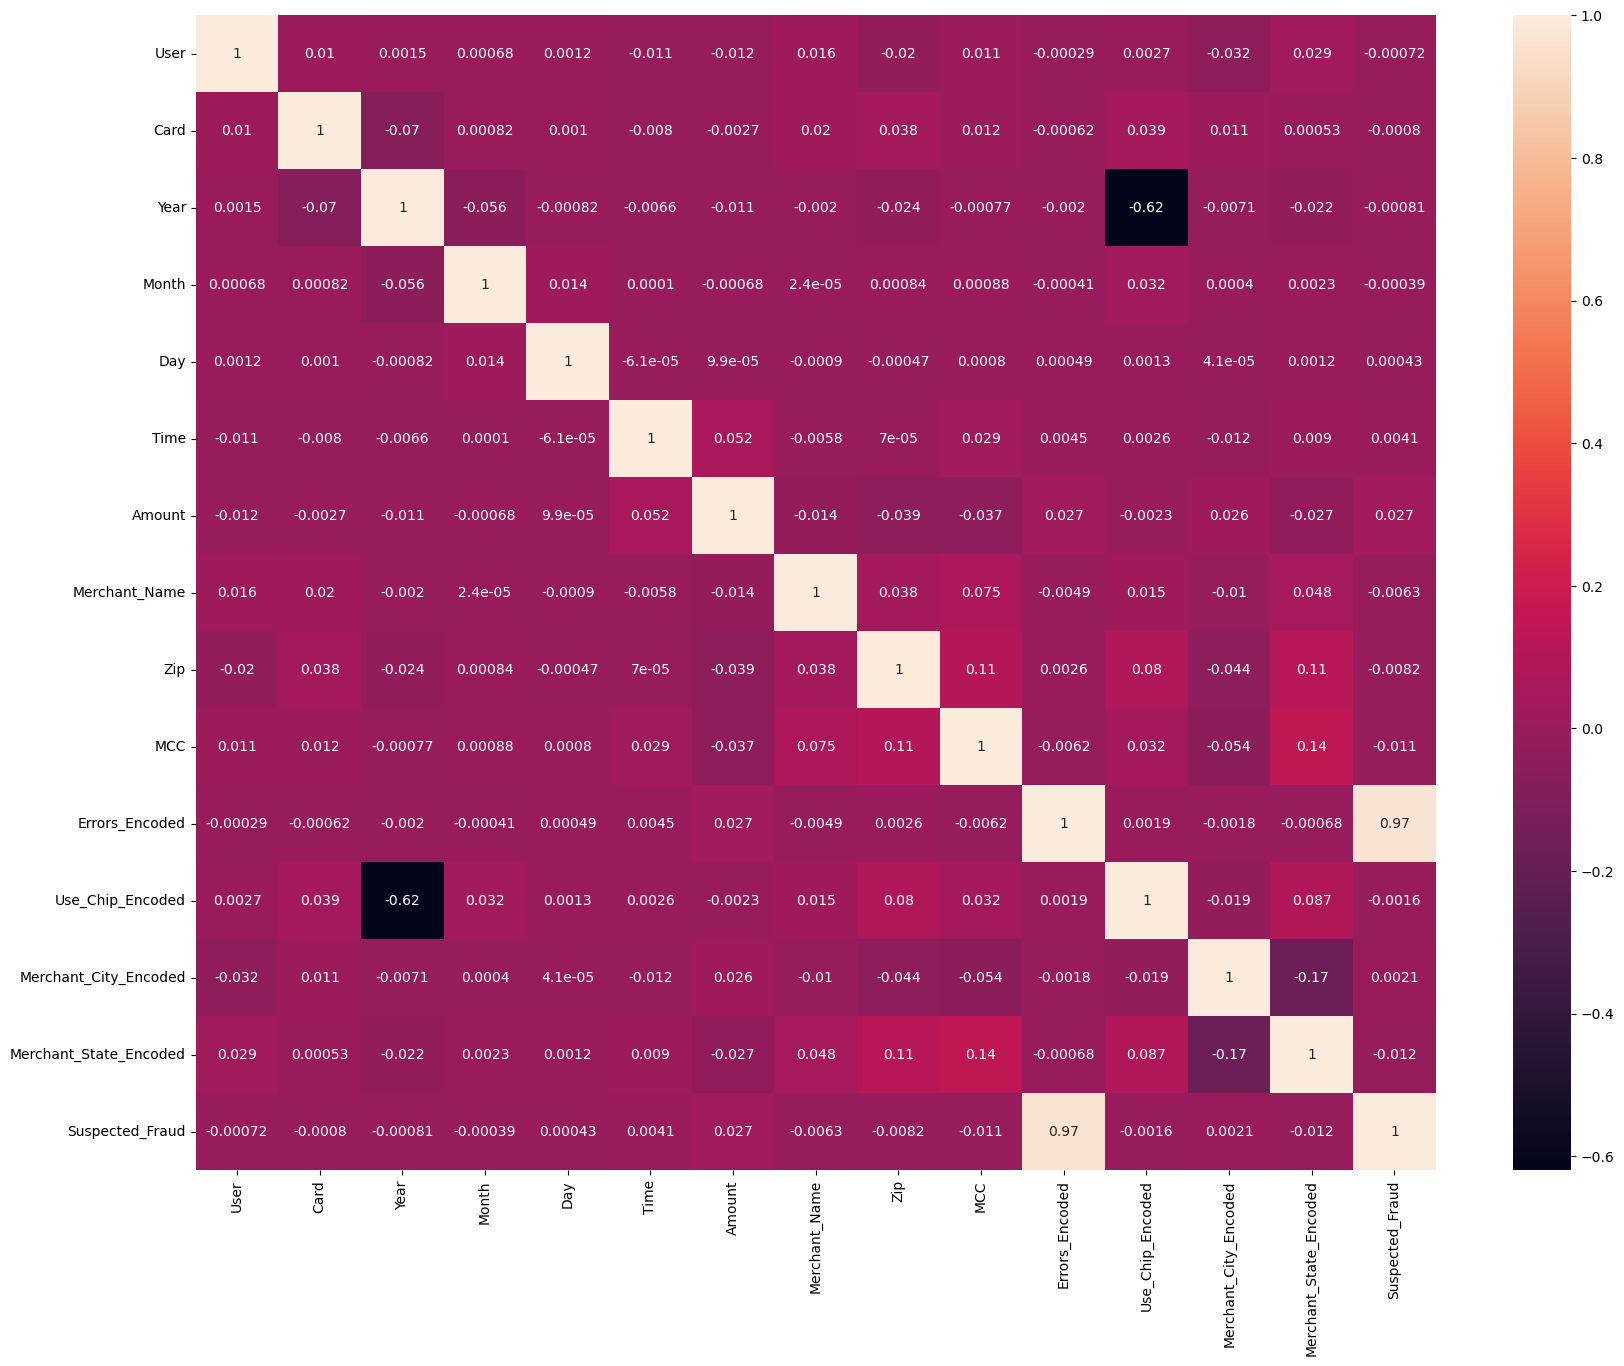

In [37]:
plt.figure(figsize=(20,15))
sns.heatmap(cred_trans.corr(), annot=True, cmap='rocket')
plt.show()

> ### In the above heatmap the only strong correlation we can see within our dataset is between type of transaction (Use_chip) and Year with a correlation coefficient of -0.62. However, the rest of the dataset is not giving us any strong correlations to indicate any suspicious fraudulent causes. This is to be expected as the dataset is large and unlabelled dataset with no target.

## Sub-Sampling Data
> Let's work with a dataframe that contains just the errors (containing 38592 rows) and concatenate this with an equal number
> of rows with the non-erroneous data so that we're working with a fair sample size.

In [38]:
def subsample_data(df,n=38592,random_state=123):
    """
    get an undersampled version of dataset containing erroneous and non_erroneous in 1:1 ratio 
    """
    df_errors = df.loc[cred_trans['Suspected_Fraud'] != 0].copy() ## Dataframe containing 'Suspected Fraud' i.e. Erroneous data
    non_errors = df.loc[cred_trans['Suspected_Fraud'] == 0].copy() ## Dataframe containing 'Suspected Fraud' i.e. Non-Erroneous data
    df_non_errors = non_errors.sample(n=n, random_state=random_state)
    X_concat = pd.concat([df_errors, df_non_errors])

    print(X_concat.shape)
    return X_concat

In [39]:
X = subsample_data(cred_trans)
X.head()

(77184, 15)


User  Card  Year  Month  Day  Time  Amount        Merchant_Name      Zip  \
3       0     0  2002      9   12     6  122.10  4060646732831064559  91750.0   
51      0     0  2003     10    1     6  121.12  1913477460590765860  91750.0   
86      0     0  2005      2   10    19   15.85  5817218446178736267  91750.0   
100     0     0  2005      5   13    13   61.40  2027553650310142703  84084.0   
119     0     0  2005     11   27     6  118.52  -245178307025547046  91750.0   

      MCC  Errors_Encoded  Use_Chip_Encoded  Merchant_City_Encoded  \
3    5411              20                 2                   5150   
51   5300              20                 2                   5150   
86   5912              14                 2                   5150   
100  5541              22                 2                  10619   
119  5311              20                 2                   5150   

     Merchant_State_Encoded  Suspected_Fraud  
3                        26                1  
51                       26                1  
86                       26                1  
100                     187                1  
119                      26                1

In [40]:
## Let's drop the 'Suspected Fraud Column' to exclude this out from the modelling. Let's create a copy of the X dataframe
X_copy = X.drop(columns=['Suspected_Fraud']).copy()
X_copy.head()

User  Card  Year  Month  Day  Time  Amount        Merchant_Name      Zip  \
3       0     0  2002      9   12     6  122.10  4060646732831064559  91750.0   
51      0     0  2003     10    1     6  121.12  1913477460590765860  91750.0   
86      0     0  2005      2   10    19   15.85  5817218446178736267  91750.0   
100     0     0  2005      5   13    13   61.40  2027553650310142703  84084.0   
119     0     0  2005     11   27     6  118.52  -245178307025547046  91750.0   

      MCC  Errors_Encoded  Use_Chip_Encoded  Merchant_City_Encoded  \
3    5411              20                 2                   5150   
51   5300              20                 2                   5150   
86   5912              14                 2                   5150   
100  5541              22                 2                  10619   
119  5311              20                 2                   5150   

     Merchant_State_Encoded  
3                        26  
51                       26  
86                       26  
100                     187  
119                      26

In [41]:
helper.plot_cluster_evaluation(unscaled_inertia,unscaled_sc,k_range, "Unscaled Data - Elbow Method", "Unscaled Data - Silhouette Coefficient", )

NameError: name 'unscaled_inertia' is not defined

In [ ]:
scaler = MinMaxScaler()
X_copy = X.drop(columns=['Suspected_Fraud']).copy()

X_scaled = scaler.fit_transform(X_copy)

db = DBSCAN(eps=0.5, min_samples=6, n_jobs=-1).fit(X_scaled) ## We played around with tweaking the epsilon value and minimum sample size.

# Get the cluster labels (aka numbers)
pred_labels = db.labels_

# Count the total number of clusters
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

In [ ]:
# Print model results
print(f'Estimated number of clusters: {n_clusters}')

Estimated number of clusters: 5


In [ ]:
# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')

Silhouette Coefficient: 0.190


In [ ]:
print(set(pred_labels)) ## Printing the unique predicted labels

{0, 1, 2, 3, 4, -1}


In [49]:
import helper
import plotly.express as px

In [54]:
def plot_clusters_3d(X_sc_copy, labels):
    fig = px.scatter_3d(X_copy, x='Card', y='Merchant_City_Encoded', z='Use_Chip_Encoded', color=labels)
    fig.show()


In [56]:
#plot_cluster_subplots(X_sc_copy,n_clusters=5,main_title='DBSCAN Cluster Plot')
plot_clusters_3d(X_sc_copy, pred_labels)